In [1]:
import os
import tensorflow as tf
from methods.config import *
from methods.clean_data import Data_Prep
from methods.build_nn_model import build_model
from methods.nn import get_NN_results
from methods.var import get_VAR_results
from methods.model_results import get_model_details
from methods.data_methods import prepare_model_data
from methods.plot import plot_variables, plot_results, cluster_columns
from methods.residual_bootstrap import get_prediction_intervals
import shap

d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\Python Projects\Act

# Select Model

In [2]:
end_year = 2019  # Select from 2006, 2010, 2017 and 2019
variable = "GS5"  # Select from CPIAUCSL, GS5, RPI and UNRATE
output_steps = 1  # Select from 1, 3, 6, 12 and 24

# Vector Auto-Regression

In [3]:
data_prep = Data_Prep(DATA_PATH, TRANSFORM_PATH)
data_prep.transform_to_supervised_learning(
    NA_CUTOFF,
    TARGET_VARIABLES,
    output_steps=output_steps,
    start=f"{START_YEAR}-01-01",
    end=f"{end_year}-01-01",
)
var_dataset = data_prep.supervised_dataset
Var_results = get_VAR_results(
    var_dataset, test_steps=TEST_STEPS, val_steps=VAL_STEPS, output_steps=output_steps
)

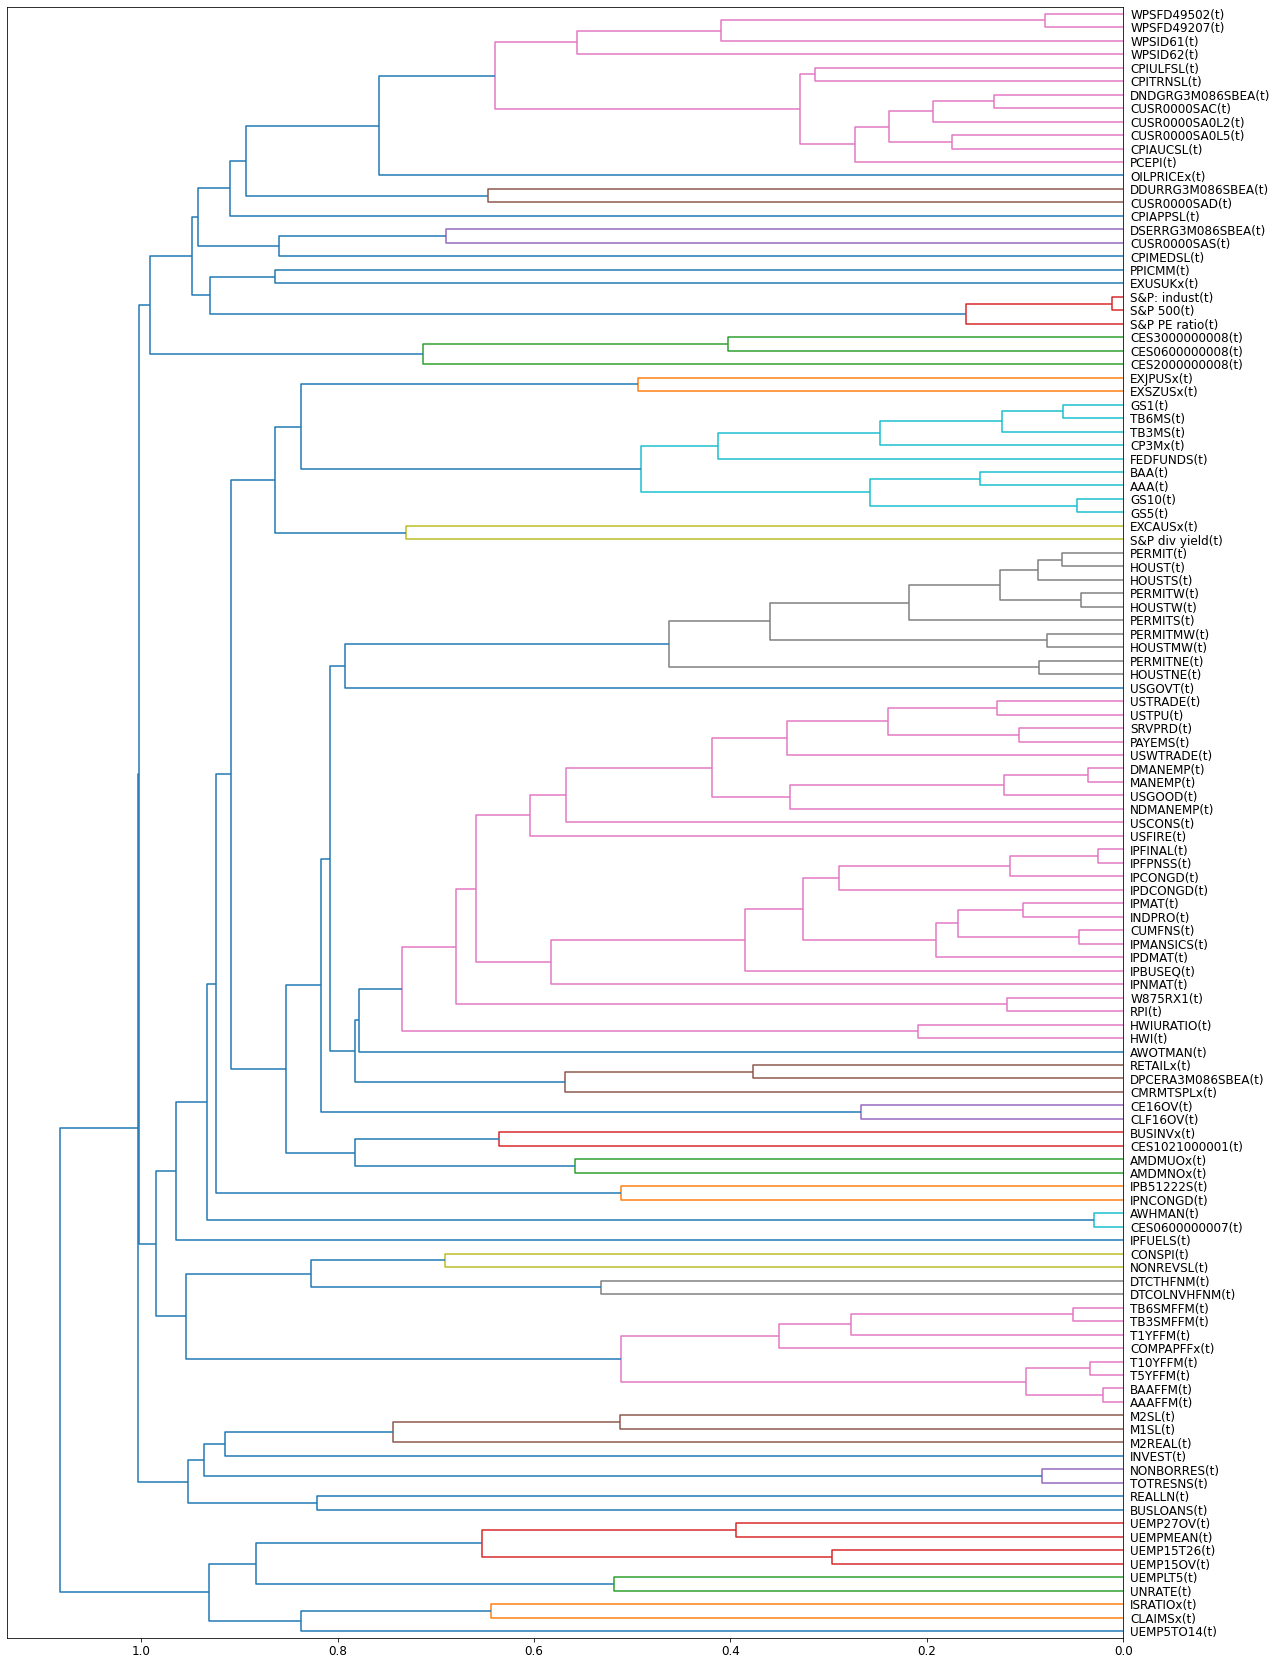

In [4]:
cluster_columns(
    var_dataset["transformed_data"][var_dataset["X_variables"]], figsize=(20, 30)
)

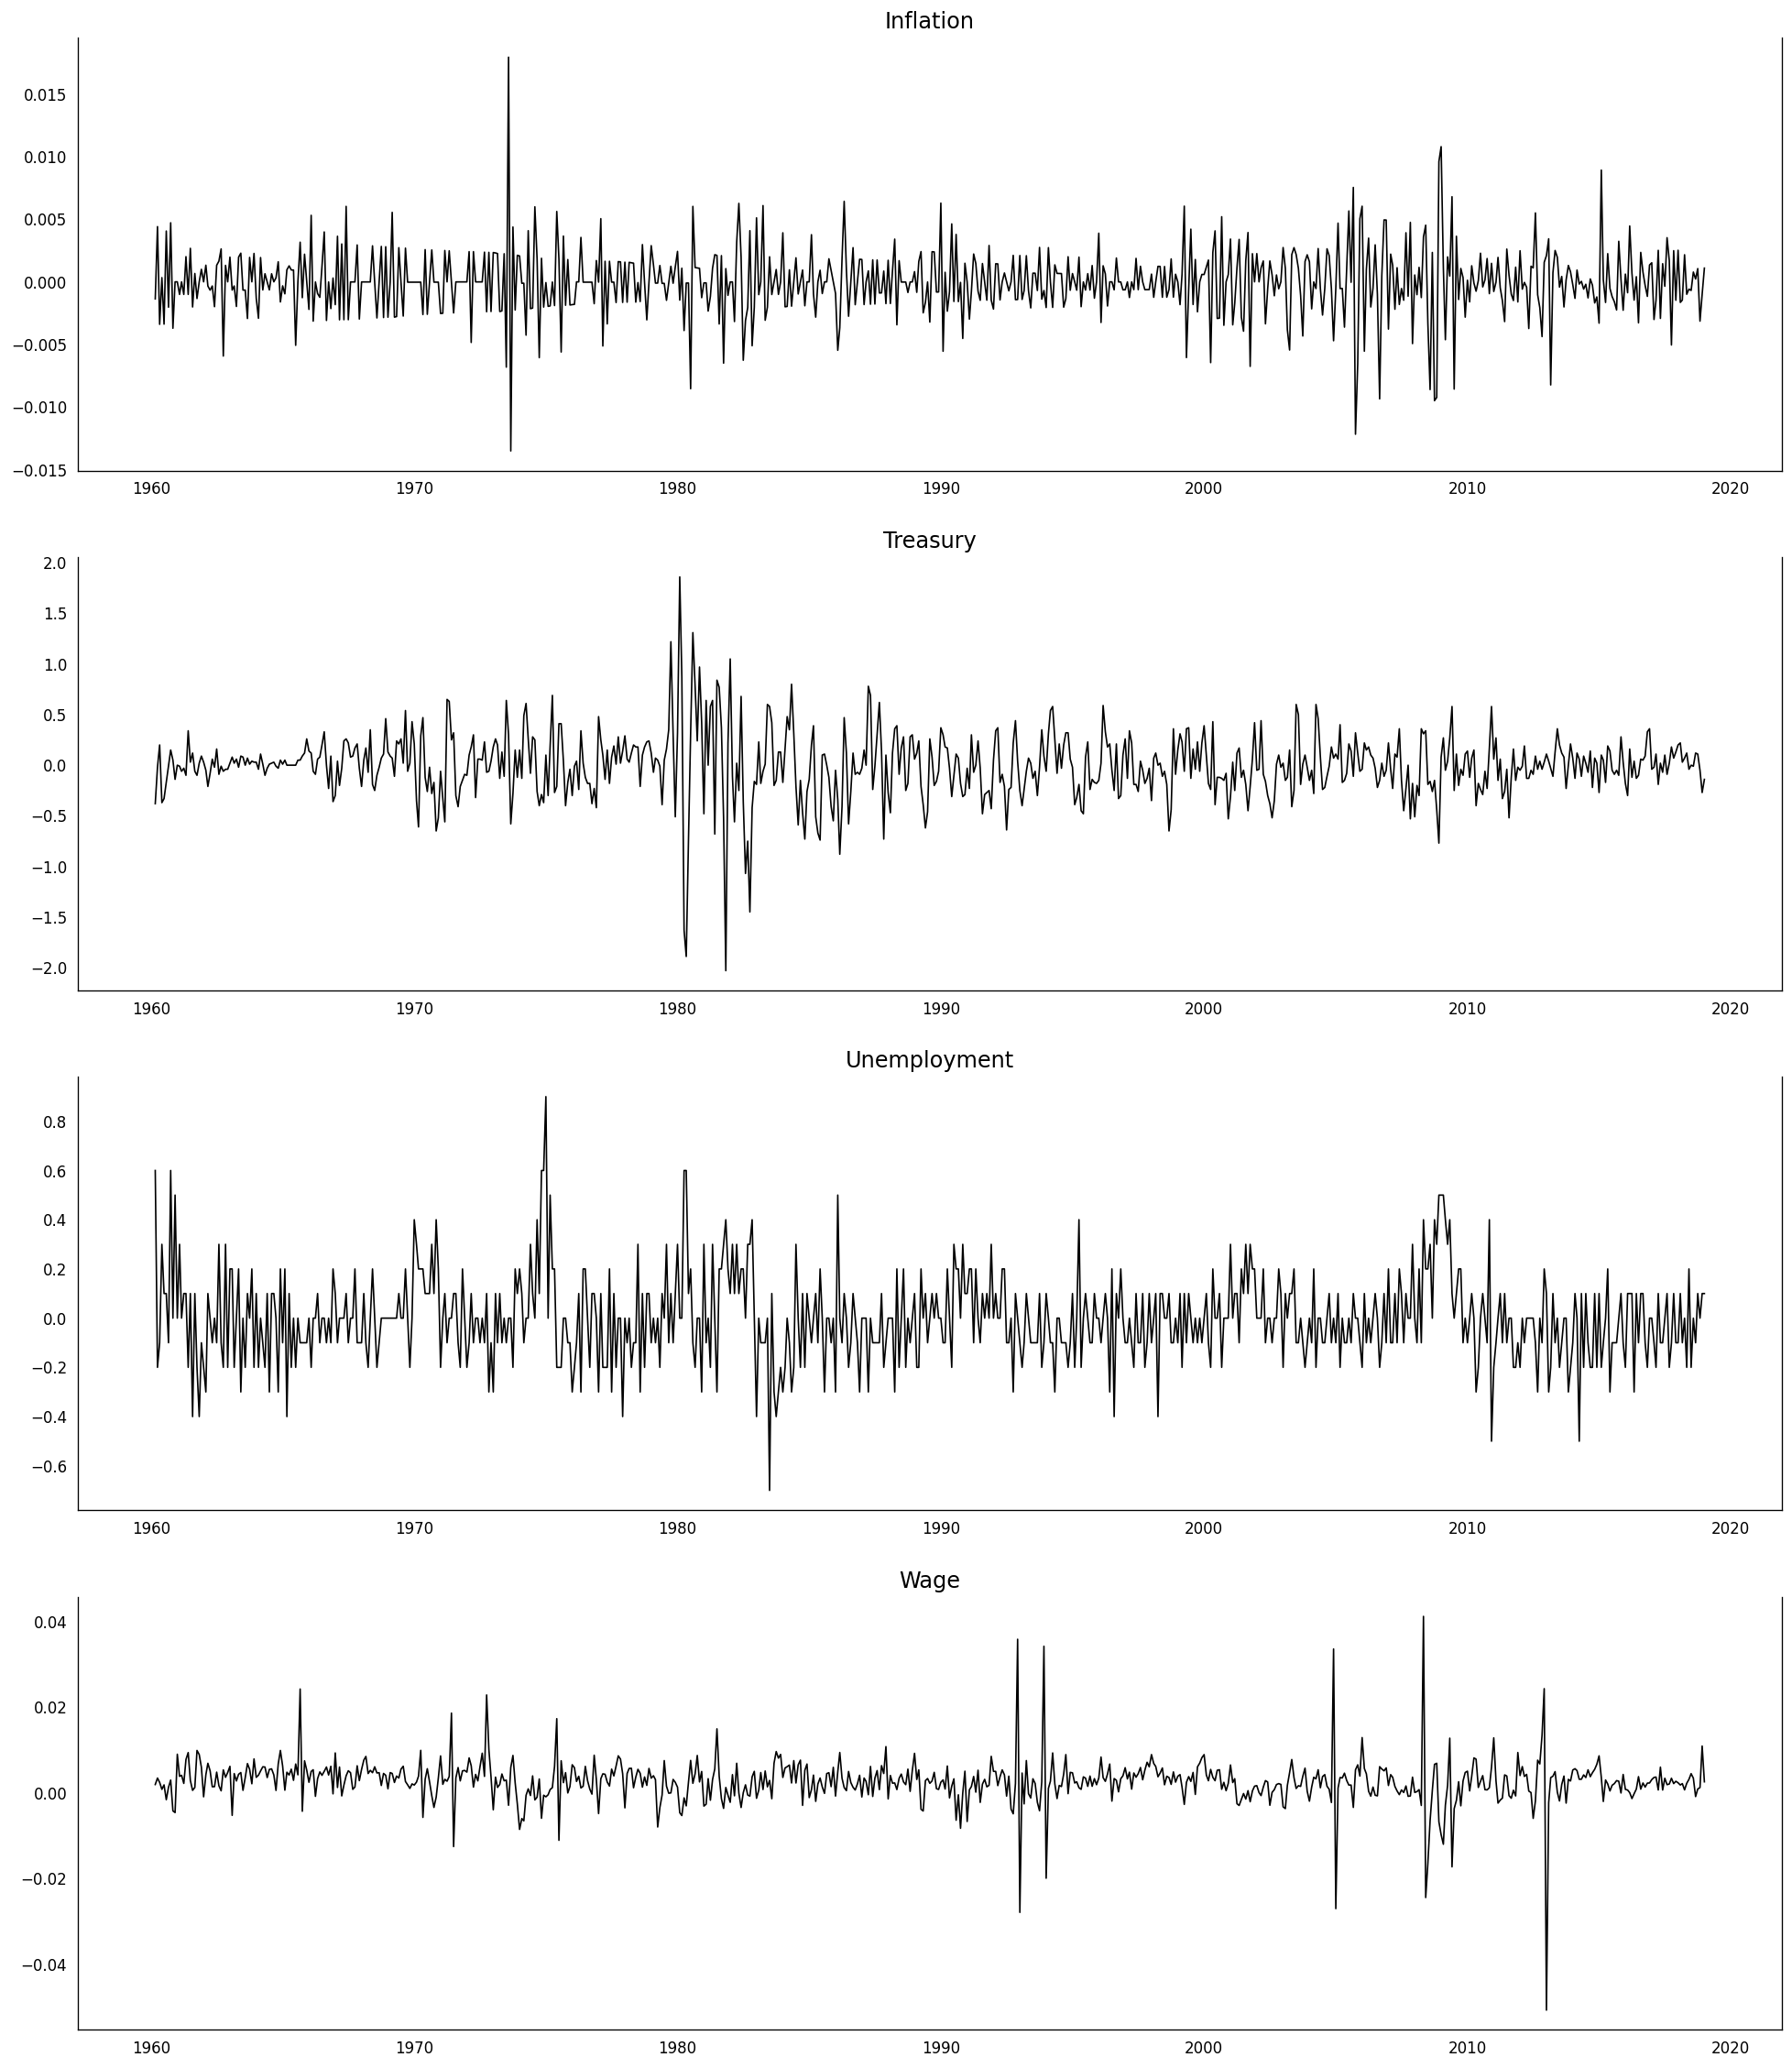

In [5]:
plot_variables(var_dataset)

# Neural Network

In [6]:
model_details = get_model_details(end_year, variable, output_steps)
look_back_steps = int(model_details["look_back_years"] * 12)
number_of_pca = model_details["number_of_pca"]

In [7]:
model_details["model_parameters"]

{'learning_rate': 0.001,
 'CNN_layers': 1,
 'LSTM_layers': 1,
 'Dense_layers': 1,
 'Dropout_prob': 0.5,
 'CNN_0_filters': 128,
 'LSTM_0_units': 160,
 'Dense_0_units': 96,
 'CNN_1_filters': 32,
 'LSTM_1_units': 128,
 'Dense_1_units': 128,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': 'f822973a668934d3f94f1f69238cdc2d'}

In [8]:
data_prep.transform_to_supervised_learning(
    NA_CUTOFF,
    [variable],
    output_steps,
    start=f"{START_YEAR}-01-01",
    end=f"{end_year}-01-01",
)
dataset = data_prep.supervised_dataset
full_dataset = dataset["transformed_data"]

In [9]:
data = prepare_model_data(
    window=full_dataset,
    X_variables=dataset["X_variables"],
    Y_variables=dataset["Y_variables"],
    val_steps=VAL_STEPS,
    look_back=look_back_steps,
    test_steps=TEST_STEPS,
    remove_outlier=REMOVE_OUTLIER,
    number_of_pca=number_of_pca,
    target_variables=dataset["target_variables"],
)

data["train_X"] = data["train_X"][len(data["train_X"]) % BATCH_SIZE :]
data["train_Y"] = data["train_Y"][len(data["train_Y"]) % BATCH_SIZE :]

In [10]:
model = build_model(data, model_details)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 128)           384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 160)               184960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 96)                15456     
____

In [11]:
NN_results = get_NN_results(
    model,
    data,
    VAL_STEPS,
    TEST_STEPS,
    look_back_steps,
    dataset,
    BATCH_SIZE,
    EPOCHS,
    executions=1,
)

Fitting Train: 1
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Fitting Val: 1


# Compare Results

In [12]:
val_result = {
    k: v / Var_results["val"]["error"][k] for k, v in NN_results["val"]["error"].items()
}
val_result["average"] = sum(val_result.values()) / len(val_result.values())
val_result_raw = {
    k: v / Var_results["val"]["error_raw"][k]
    for k, v in NN_results["val"]["error_raw"].items()
}
val_result

{'GS5': 0.8047912398078862, 'average': 0.8047912398078862}

In [13]:
test_result = {
    k: v / Var_results["test"]["error"][k]
    for k, v in NN_results["test"]["error"].items()
}
test_result["average"] = sum(test_result.values()) / len(test_result.values())
test_result_raw = {
    k: v / Var_results["test"]["error_raw"][k]
    for k, v in NN_results["test"]["error_raw"].items()
}
test_result

{'GS5': 1.0336463318212985, 'average': 1.0336463318212985}

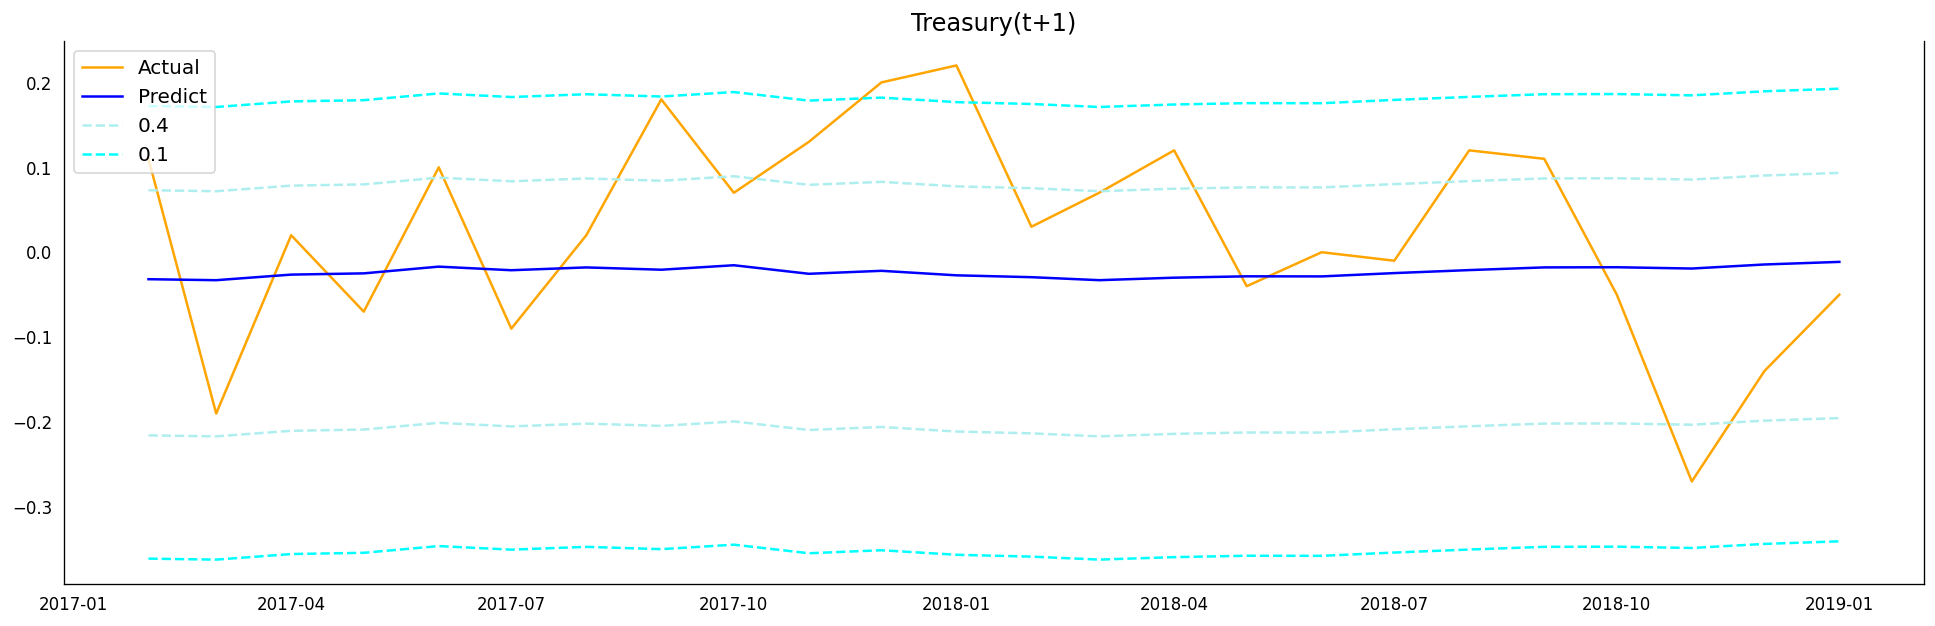

In [14]:
intervals = get_prediction_intervals(NN_results)
plot_results(
    result=NN_results,
    period="test",
    target_variable=variable,
    show_interval=True,
    intervals=intervals,
)

In [15]:
import shap

In [16]:
# def get_shap_values(model, train_X, test_X):
#     explainer = shap.DeepExplainer(model, train_X)
#     return explainer.shap_values(test_X)[0].squeeze()

In [17]:
explainer = shap.DeepExplainer(NN_results.test_models[0], NN_results.data.train_X)

keras is no longer supported, please use tf.keras instead.
